In [12]:
from dotenv import load_dotenv

import os

load_dotenv()

True

## Checando Tools 

Vamos importar as tools criadas anteriormente! 

In [13]:
from tools import *

In [14]:
trends = create_trends_tool()
trends_text = trends.invoke({"country": "brazil", 
                             "head": 3})
trends_list = to_list(trends_text)
trends_list

['Beatriz Haddad Maia', 'Cessar-fogo Gaza', 'AZUL4']

In [15]:
contents_news = get_serper_with_scrapping(trends_list, k=5)

100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


In [16]:
contents_news

{'Beatriz Haddad Maia': [{'title': 'João Fonseca e Bia Haddad têm destinos diferentes no Australian Open',
   'link': 'https://www.terra.com.br/esportes/tenis/joao-fonseca-e-bia-haddad-tem-destinos-diferentes-no-australian-open,e5ba253fafc4b493303b219c76c11dc3vgg2a7ma.html',
   'snippet': 'A madrugada no Australian Open 2025 trouxe emoções contrastantes para os torcedores brasileiros. Beatriz Haddad Maia e João Fonseca,...',
   'date': 'há 2 horas',
   'source': 'Terra',
   'imageUrl': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQZPamYXb3axNUZEo7rXv7PzkqhFeffRHmJ7lT0VgmCV3yrVTx6uRaG_dM&usqp=CAI&s',
   'position': 1,
   'content': "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJoão Fonseca e Bia Haddad têm destinos diferentes no Australian Open\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nScript = https://s1.trrsf.com/update-1736967909/fe/zaz-ui-t360/_js/transition.min.js\nScript = https://pagead2.googlesyndication.com/pagead/

## Construção do Agent

Para construir o agente, vamos utilizar as funções que construimos anteriormente. A ideia central é um agente que colete quais são as tendências de pesquisa no Google Trends, pesquise essas tendências no Google Api (SerpApi), faça scrapping dos resultados e crie uma newsletter com as informações. Para a construção desses fluxos, é comum fazermos o desenho do fluxo (que pode ser representado por um grafo).

<img src="../imgs/agent_trends.png" width="800">

Os componentes do agente são:

1. ``Estado``: é o objeto que irá armazenar as informações do agente ao longo do grafo.
2. ``Nós``: são as funções que irão realizar as ações do agente.
3. ``Transições (arestas)``: são as funções que irão decidir qual será o próximo nó a ser executado (ela pode ser condicional ou não).

### Estado do Grafo

In [17]:
from typing_extensions import TypedDict
from typing import List, Dict, Any

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        country: country of the trends
        head: number of trends to get
        k: number of news to get
        trends: list of trends
        news: dict of news about each trend
        newsletter: newsletter from the news
    """
    country: str
    head: int
    k: int
    trends: List[str]
    news: dict
    subjects: List[str] # New attribute
    newsletter: str

### Chains

Aqui definimos as cadeias de execução do agente. Normalmente separamos dessa forma pra que a construção dos nós fique mais organizada.

In [18]:

from operator import itemgetter
from typing import TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

def format_news(news: dict) -> str:
    """
    Format the news to be used in the newsletter.

    Args:
        news: dict of news about each trend

    Returns:
        str: formatted news
    """
    news_str = ""
    for trend, content in news.items():
        news_str += f"-----**{trend}**-----\n"
        for i, new in enumerate(content):
            title = new["title"]
            txt_content = new["content"]
            link = new["link"]
            
            news_str += f"""
            title: {title}
            link: {link}
            content: {txt_content}
            """
        news_str += "\n"
    return news_str

def write_newsletter(news: dict, 
                     provider: str="openai",
                     model_name: str="gpt-4o-mini",
                     temperature: float=0.2) -> str:
    """
    Generate a newsletter from the news.
    
    Args:
        news: dict of news about each trend
        provider: provider of the language model
        model_name: name of the language model
        temperature: temperature of the language model
        
    Returns:
        str: newsletter from the news
    """
    
    if provider == "openai": # Sugestão: gpt-4o-mini
        llm = ChatOpenAI(model=model_name, temperature=temperature)
    elif provider == "groq": # Sugestão: llama-3.3-70b-versatile
        llm = ChatGroq(model=model_name, temperature=temperature)

    formatted_news = format_news(news)

    system_prompt = """
    Você é um assistente pessoal que vai escrever um newsletter sobre as notícias do dia que foram extraidas do Google Trends. Sua tarefa é resumir o conteúdo das notícias e escrever um texto informativo e interessante para o usuário. 
    
    Obs.: Sempre que possível, cite a fonte das notícias colocando o link de onde ela foi tirada.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Aqui está todo o conteúdo que você vai usar para fazer a newsletter: {input}"),
        ]
    )

    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke({"input": formatted_news})
    
    return response

### Nodes

Aqui vamos definir os nós do grafo! Como dito anteriormente, entenda os nós como sendo funções a serem executadas. Cada entrada de um nó é a saída de um nó anterior, cada execução de nó podemos ou não modificar o estado do grafo (definido anteriormente).

In [19]:
from IPython.display import Markdown

def get_trends(state: GraphState) -> dict:
    """
    Get trends from Google Trends

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET TRENDS---")
    print()
    country = state["country"]
    head = state["head"]
    subjects = state["subjects"] # New attribute
    
    if subjects:
        print("--> Assuntos adicionais: ", subjects) # New print
 
    # Get trends
    trends = create_trends_tool()
    trends_text = trends.invoke({"country": country, 
                                 "head": head})
    trends_list = to_list(trends_text)
    
    print("Trend List: ", trends_list)
    print()
    
    return {"country": country, 
            "head": head, 
            "trends": trends_list}

def get_serper_and_scrapping(state: GraphState) -> dict:
    """
    Get news from SerpAPI and scrap the content

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET SERPER AND SCRAPPING---")
    print()
    trends = state["trends"]
    k = state["k"]
    subjects = state["subjects"] # New attribute
    
    # Get news
    news = get_serper_with_scrapping(queries=trends + subjects, k=k)
    keys_from_serper = news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(news[trend]))):
            print(news[trend][i]["title"])
        print()
    
    return {"news": news}

def create_newsletter(state: GraphState) -> dict:
    """
    Create a newsletter from the news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """

    print("---CREATE NEWSLETTER---")
    print()
    news = state["news"]
    
    # Create newsletter
    newsletter = write_newsletter(news=news, 
                                  provider="openai",
                                  model_name="gpt-4o-mini",
                                  temperature=0.2)
    print("Aqui está a newsletter: ", newsletter)
    display(Markdown(newsletter))
    return {"newsletter": newsletter}

### Workflow

Por fim, com os nós construidos e as cadeias definidas, podemos construir o workflow do agente.

In [20]:
from langgraph.graph import END, StateGraph

def compile_workflow():
    """ 
    Compiles the workflow for creating a newsletter from Google Trends.
    
    Returns:
        app (StateGraph): The compiled workflow.
    """
    
    # Define the graph
    workflow = StateGraph(GraphState)
    
    # Define the nodes
    workflow.add_node("get_trends", get_trends)
    workflow.add_node("get_serper_and_scrapping", get_serper_and_scrapping)
    workflow.add_node("create_newsletter", create_newsletter)

    # Build graph
    workflow.set_entry_point('get_trends')
    workflow.add_edge("get_trends", "get_serper_and_scrapping")
    workflow.add_edge("get_serper_and_scrapping", "create_newsletter")
    workflow.add_edge("create_newsletter", END)

    # Compile
    app = workflow.compile()
    return app

In [21]:
app = compile_workflow()

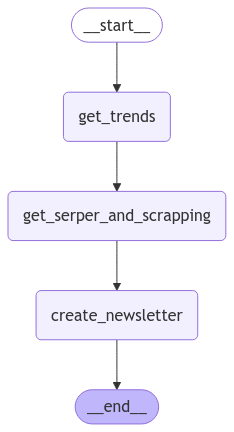

In [22]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [23]:
response = app.invoke({"country": "brazil",
                       "head": 5,
                       "subjects": ["Educação"],
                       "k": 3})

---GET TRENDS---

--> Assuntos adicionais:  ['Educação']
Trend List:  ['Beatriz Haddad Maia', 'Cessar-fogo Gaza', 'AZUL4', 'Jogo joao Fonseca', 'Matheus Pereira']

---GET SERPER AND SCRAPPING---



100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


---Beatriz Haddad Maia---
João Fonseca e Bia Haddad têm destinos diferentes no Australian Open
Bia Haddad joga o suficiente e avança à terceira rodada no Australian Open
Bia Haddad avança no Australian Open; João Fonseca é eliminado

---Cessar-fogo Gaza---
Israel ataca a Faixa de Gaza depois de aprovar acordo de cessar-fogo
Cessar-fogo em Gaza: as perguntas ainda sem resposta sobre o acordo, que teve votação adiada em Israel
Gabinete de Israel adia votação sobre cessar-fogo em Gaza

---AZUL4---
Gol (GOLL4) e Azul (AZUL4) assinam acordo visando fusão
Ações de Azul (AZUL4) e Gol (GOLL4) disparam com acordo para avaliar fusão
Mercado financeiro hoje: Azul (AZUL4) e Gol (GOLL4) chegam a acordo sobre fusão, Pagbank e Stone têm cortes de recomendação; veja destaques

---Jogo joao Fonseca---
Quando é o próximo jogo de João Fonseca? Veja onde assistir ao vivo, dia e horário
Australian Open: João Fonseca perde para Sonego em batalha de quase 4h
João Fonseca começa com tudo, mas sofre com dia in

**Newsletter de Notícias - 16 de Janeiro de 2025**

**1. Australian Open: Bia Haddad avança, João Fonseca é eliminado**
A madrugada de ontem trouxe emoções contrastantes para os torcedores brasileiros no Australian Open. Beatriz Haddad Maia venceu a russa Erika Andreeva com parciais de 6/2 e 6/3, garantindo sua vaga na terceira rodada. Bia, atual número 14 do mundo, agora se prepara para enfrentar Madison Keys. Por outro lado, João Fonseca, de apenas 18 anos, lutou bravamente contra Lorenzo Sonego, mas foi eliminado após uma batalha de quase quatro horas, com parciais de 6/7, 6/3, 6/1, 3/6 e 6/3. Apesar da derrota, Fonseca deixou o torneio com a certeza de que tem um futuro promissor no tênis. [Leia mais na CNN Brasil](https://www.cnnbrasil.com.br/esportes/tenis/bia-haddad-avanca-no-australian-open-joao-fonseca-e-eliminado/).

**2. Cessar-fogo em Gaza: Ataques continuam após acordo**
Após um acordo de cessar-fogo entre Israel e Hamas, a situação em Gaza permanece tensa. Israel lançou ataques que resultaram na morte de pelo menos 81 palestinos, o maior número de vítimas em um único dia em mais de uma semana. A situação levanta preocupações sobre a eficácia do cessar-fogo e a segurança dos civis na região. [Leia mais na CNN Brasil](https://www.cnnbrasil.com.br/internacional/israel-ataca-a-faixa-de-gaza-depois-de-aprovar-acordo-de-cessar-fogo/).

**3. Gol e Azul assinam acordo para fusão**
As companhias aéreas Gol e Azul assinaram um memorando de entendimento para explorar uma fusão que poderia resultar em uma nova empresa controlando 60% do mercado aéreo brasileiro. A fusão depende da conclusão da recuperação judicial da Gol, prevista para abril. [Leia mais no InfoMoney](https://www.infomoney.com.br/mercados/acoes-de-azul-azul4-e-gol-goll4-disparam-com-acordo-para-avaliar-fusao/).

**4. Programa Mais Professores é lançado**
O governo federal lançou o programa Mais Professores, que visa valorizar e qualificar cerca de 2,3 milhões de docentes no Brasil. O programa inclui ações como a criação de uma Prova Nacional Docente e a oferta de bolsas de R$ 1.050 para estudantes de licenciatura. O objetivo é atrair novos professores e melhorar a qualidade da educação no país. [Leia mais na CartaCapital](https://www.cartacapital.com.br/educacao/governo-lanca-o-mais-professores-entenda-os-principais-pontos-do-programa/).

**5. Lei que restringe uso de celulares em escolas**
Uma nova lei sancionada pelo presidente Lula proíbe o uso de celulares em escolas de educação básica, visando promover um ambiente escolar mais saudável. Educadores e especialistas divergem sobre a eficácia da medida, ressaltando a necessidade de apoio dos pais e da comunidade escolar para sua implementação. [Leia mais no O Tempo](https://www.otempo.com.br/brasil/2025/1/16/especialistas-da-educacao-divergem-sobre-lei-federal-que-proibe-o-uso-do-celular-em-sala-de-aula0).

**6. Matheus Pereira fala sobre futuro no Cruzeiro**
Após marcar um gol relâmpago no empate contra o São Paulo, Matheus Pereira admitiu que recebeu propostas de outros clubes, mas não confirmou sua permanência no Cruzeiro. O jogador expressou sua felicidade em estar no clube, mas deixou seu futuro em aberto. [Leia mais na CNN Brasil](https://www.cnnbrasil.com.br/esportes/futebol/cruzeiro-x-sao-paulo-veja-o-gol-de-matheus-pereira-com-30-segundos-de-jogo/).

Fique atento às atualizações e não perca as próximas edições!

## Conclusão:

Com essa aplicação simples é possível ver como podemos construir um agente que coleta informações de tendências de pesquisa e cria uma newsletter. Para além dessa ideia, é possível construir aplicações mais robustas, que envolvem ``novos nós, novas cadeias, novos estados ou até transições condicionais``. 

### Tarefa de casa:

1. Crie um novo nó que envie a newsletter por email. Note que para isso você precisa incluir uma lista de emails que irão receber a newsletter. (``Dica:`` Faça a lista de emails ser um parâmetro na entrada do grafo, assim você pode passar a lista de emails como parâmetro para o nó que envia a newsletter).

2. Calcule quanto custa em média uma newsletter. (``Dica:`` Use o LangSmith).

3. Construa um classificador que classifica as notícias de acordo com o assunto. Especificamente, classifique se a notícia fala sobre futebol ou não (``binário``). No fim, faça a newsletter somente baseada em assuntos de futebol (seu classificador será um filtro).

4. Crie um ``conditional_edge`` que verifica se existe noticia ou não de futebol. Caso não tenha noticias de futebol no Google Trends, crie um nó que vai pesquisar sobre seu time de futebol favorito e adicione na newsletter apenas os ultimos assuntos dele.

5. Crie uma ``API`` (com ``FastAPI``, por exemplo), que contenha um endpoint que recebe:

```python
{"country": "brazil",
 "head": 5,
 "k": 3}
 ```

E devolve o estado do grafo.